# Assignment 5 - Ensemble Learning

## Exercise 5
For your method of choice, find out what widely used implementations are available in your favourite programming language and apply the method to a prediction problem you find interesting (see, for instance the UCI Machine Learning repository for interesting datasets). Write a short description (min. 100 words) of your findings, including what dataset and implementation you used, how you set up your experiment, what the effect of different parameter settings was, what the performance was, which variables were important, etc.).


Chosen Dataset: [Wine Quality Data Set](http://archive.ics.uci.edu/ml/datasets/Wine+Quality)

In [1]:
# import libraries
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

### Data Loading

In [2]:
red_wine_df = pd.read_csv("./Data/winequality-red.csv", sep=";")
white_wine_df = pd.read_csv("./Data/winequality-white.csv", sep=";")

### Exploratory Data Analysis

For simplicity, the 2 datasets are combined

In [3]:
wine_df = pd.concat([red_wine_df, white_wine_df], ignore_index=True, sort=False)

In [4]:
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 609.2 KB


In [6]:
wine_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


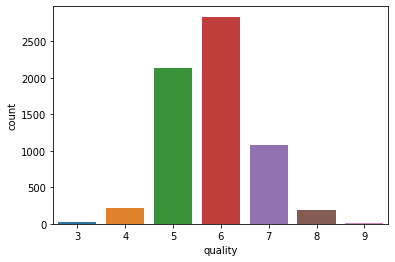

In [7]:
# output distribution over 0-10
sns.countplot(x='quality', data=wine_df);

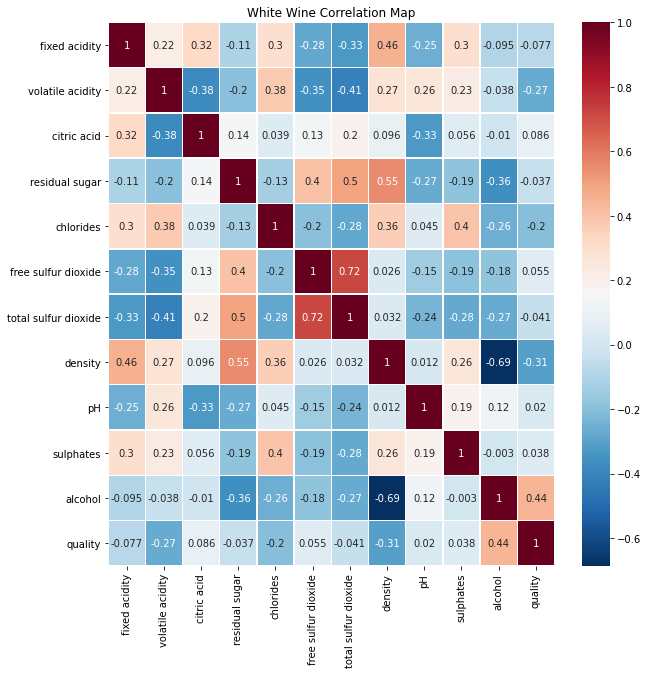

In [8]:
plt.figure(figsize=(10,10))
sns.heatmap(wine_df.corr(), cmap='RdBu_r', annot=True, linewidths=0.5)
plt.title("White Wine Correlation Map")
plt.show()

### Data Pre-processing

No data cleaning is required as the dataset has no missing attributes.

In [9]:
# extract X and y
X = wine_df.iloc[:,:-1]
y = wine_df['quality']

In [10]:
# Normalize X
sc = StandardScaler()
X = sc.fit_transform(X)

In [11]:
# train-test split (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    shuffle=True, random_state=42)

In [12]:
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (5197, 11)
Shape of y_train:  (5197,)
Shape of X_test:  (1300, 11)
Shape of y_test:  (1300,)


### GridSearch CV on Random Forest

In [13]:
rfc = RandomForestClassifier(random_state=42, verbose=2)

In [20]:
param_grid = { 
    'n_estimators': [100, 200, 500, 1000, 2000, 5000],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_depth' : [None, 4, 5, 6, 7, 8, 9, 10],
    'criterion' : ['gini', 'entropy'],
    'bootstrap' : [True, False]
}

In [21]:
CV_rfc = GridSearchCV(rfc, param_grid, n_jobs=10, cv=10, verbose=2)

In [22]:
CV_rfc.fit(X_train, y_train)

Fitting 10 folds for each of 768 candidates, totalling 7680 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   10.4s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  4.3min
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed: 12.7min
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed: 17.7min
[Parallel(n_jobs=10)]: Done 993 tasks      | elapsed: 26.4min
[Parallel(n_jobs=10)]: Done 1438 tasks      | elapsed: 39.1min
[Parallel(n_jobs=10)]: Done 1965 tasks      | elapsed: 56.4min
[Parallel(n_jobs=10)]: Done 2572 tasks      | elapsed: 79.6min
[Parallel(n_jobs=10)]: Done 3261 tasks      | elapsed: 101.5min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed: 139.2min
[Parallel(n_jobs=10)]: Done 4881 tasks      | elapsed: 165.9min
[Parallel(n_jobs=10)]: Done 5812 tasks      | elapsed: 205.0min
[Parallel(n_jobs=10)]: Done 6825 tasks      | elapsed: 246.8min
[Parallel(n_jobs=10)]: Done 7680 out of 7680 | elapsed: 293.9min finished
[Parallel(n_jobs=1)]: Using ba

building tree 1 of 5000
building tree 2 of 5000
building tree 3 of 5000
building tree 4 of 5000
building tree 5 of 5000
building tree 6 of 5000
building tree 7 of 5000
building tree 8 of 5000
building tree 9 of 5000
building tree 10 of 5000
building tree 11 of 5000
building tree 12 of 5000
building tree 13 of 5000
building tree 14 of 5000
building tree 15 of 5000
building tree 16 of 5000
building tree 17 of 5000
building tree 18 of 5000
building tree 19 of 5000
building tree 20 of 5000
building tree 21 of 5000
building tree 22 of 5000
building tree 23 of 5000
building tree 24 of 5000
building tree 25 of 5000
building tree 26 of 5000
building tree 27 of 5000
building tree 28 of 5000
building tree 29 of 5000
building tree 30 of 5000
building tree 31 of 5000
building tree 32 of 5000
building tree 33 of 5000
building tree 34 of 5000
building tree 35 of 5000
building tree 36 of 5000
building tree 37 of 5000
building tree 38 of 5000
building tree 39 of 5000
building tree 40 of 5000
building 

building tree 338 of 5000
building tree 339 of 5000
building tree 340 of 5000
building tree 341 of 5000
building tree 342 of 5000
building tree 343 of 5000
building tree 344 of 5000
building tree 345 of 5000
building tree 346 of 5000
building tree 347 of 5000
building tree 348 of 5000
building tree 349 of 5000
building tree 350 of 5000
building tree 351 of 5000
building tree 352 of 5000
building tree 353 of 5000
building tree 354 of 5000
building tree 355 of 5000
building tree 356 of 5000
building tree 357 of 5000
building tree 358 of 5000
building tree 359 of 5000
building tree 360 of 5000
building tree 361 of 5000
building tree 362 of 5000
building tree 363 of 5000
building tree 364 of 5000
building tree 365 of 5000
building tree 366 of 5000
building tree 367 of 5000
building tree 368 of 5000
building tree 369 of 5000
building tree 370 of 5000
building tree 371 of 5000
building tree 372 of 5000
building tree 373 of 5000
building tree 374 of 5000
building tree 375 of 5000
building tre

building tree 665 of 5000
building tree 666 of 5000
building tree 667 of 5000
building tree 668 of 5000
building tree 669 of 5000
building tree 670 of 5000
building tree 671 of 5000
building tree 672 of 5000
building tree 673 of 5000
building tree 674 of 5000
building tree 675 of 5000
building tree 676 of 5000
building tree 677 of 5000
building tree 678 of 5000
building tree 679 of 5000
building tree 680 of 5000
building tree 681 of 5000
building tree 682 of 5000
building tree 683 of 5000
building tree 684 of 5000
building tree 685 of 5000
building tree 686 of 5000
building tree 687 of 5000
building tree 688 of 5000
building tree 689 of 5000
building tree 690 of 5000
building tree 691 of 5000
building tree 692 of 5000
building tree 693 of 5000
building tree 694 of 5000
building tree 695 of 5000
building tree 696 of 5000
building tree 697 of 5000
building tree 698 of 5000
building tree 699 of 5000
building tree 700 of 5000
building tree 701 of 5000
building tree 702 of 5000
building tre

building tree 990 of 5000
building tree 991 of 5000
building tree 992 of 5000
building tree 993 of 5000
building tree 994 of 5000
building tree 995 of 5000
building tree 996 of 5000
building tree 997 of 5000
building tree 998 of 5000
building tree 999 of 5000
building tree 1000 of 5000
building tree 1001 of 5000
building tree 1002 of 5000
building tree 1003 of 5000
building tree 1004 of 5000
building tree 1005 of 5000
building tree 1006 of 5000
building tree 1007 of 5000
building tree 1008 of 5000
building tree 1009 of 5000
building tree 1010 of 5000
building tree 1011 of 5000
building tree 1012 of 5000
building tree 1013 of 5000
building tree 1014 of 5000
building tree 1015 of 5000
building tree 1016 of 5000
building tree 1017 of 5000
building tree 1018 of 5000
building tree 1019 of 5000
building tree 1020 of 5000
building tree 1021 of 5000
building tree 1022 of 5000
building tree 1023 of 5000
building tree 1024 of 5000
building tree 1025 of 5000
building tree 1026 of 5000
building tr

building tree 1309 of 5000
building tree 1310 of 5000
building tree 1311 of 5000
building tree 1312 of 5000
building tree 1313 of 5000
building tree 1314 of 5000
building tree 1315 of 5000
building tree 1316 of 5000
building tree 1317 of 5000
building tree 1318 of 5000
building tree 1319 of 5000
building tree 1320 of 5000
building tree 1321 of 5000
building tree 1322 of 5000
building tree 1323 of 5000
building tree 1324 of 5000
building tree 1325 of 5000
building tree 1326 of 5000
building tree 1327 of 5000
building tree 1328 of 5000
building tree 1329 of 5000
building tree 1330 of 5000
building tree 1331 of 5000
building tree 1332 of 5000
building tree 1333 of 5000
building tree 1334 of 5000
building tree 1335 of 5000
building tree 1336 of 5000
building tree 1337 of 5000
building tree 1338 of 5000
building tree 1339 of 5000
building tree 1340 of 5000
building tree 1341 of 5000
building tree 1342 of 5000
building tree 1343 of 5000
building tree 1344 of 5000
building tree 1345 of 5000
b

building tree 1625 of 5000
building tree 1626 of 5000
building tree 1627 of 5000
building tree 1628 of 5000
building tree 1629 of 5000
building tree 1630 of 5000
building tree 1631 of 5000
building tree 1632 of 5000
building tree 1633 of 5000
building tree 1634 of 5000
building tree 1635 of 5000
building tree 1636 of 5000
building tree 1637 of 5000
building tree 1638 of 5000
building tree 1639 of 5000
building tree 1640 of 5000
building tree 1641 of 5000
building tree 1642 of 5000
building tree 1643 of 5000
building tree 1644 of 5000
building tree 1645 of 5000
building tree 1646 of 5000
building tree 1647 of 5000
building tree 1648 of 5000
building tree 1649 of 5000
building tree 1650 of 5000
building tree 1651 of 5000
building tree 1652 of 5000
building tree 1653 of 5000
building tree 1654 of 5000
building tree 1655 of 5000
building tree 1656 of 5000
building tree 1657 of 5000
building tree 1658 of 5000
building tree 1659 of 5000
building tree 1660 of 5000
building tree 1661 of 5000
b

building tree 1929 of 5000
building tree 1930 of 5000
building tree 1931 of 5000
building tree 1932 of 5000
building tree 1933 of 5000
building tree 1934 of 5000
building tree 1935 of 5000
building tree 1936 of 5000
building tree 1937 of 5000
building tree 1938 of 5000
building tree 1939 of 5000
building tree 1940 of 5000
building tree 1941 of 5000
building tree 1942 of 5000
building tree 1943 of 5000
building tree 1944 of 5000
building tree 1945 of 5000
building tree 1946 of 5000
building tree 1947 of 5000
building tree 1948 of 5000
building tree 1949 of 5000
building tree 1950 of 5000
building tree 1951 of 5000
building tree 1952 of 5000
building tree 1953 of 5000
building tree 1954 of 5000
building tree 1955 of 5000
building tree 1956 of 5000
building tree 1957 of 5000
building tree 1958 of 5000
building tree 1959 of 5000
building tree 1960 of 5000
building tree 1961 of 5000
building tree 1962 of 5000
building tree 1963 of 5000
building tree 1964 of 5000
building tree 1965 of 5000
b

building tree 2245 of 5000
building tree 2246 of 5000
building tree 2247 of 5000
building tree 2248 of 5000
building tree 2249 of 5000
building tree 2250 of 5000
building tree 2251 of 5000
building tree 2252 of 5000
building tree 2253 of 5000
building tree 2254 of 5000
building tree 2255 of 5000
building tree 2256 of 5000
building tree 2257 of 5000
building tree 2258 of 5000
building tree 2259 of 5000
building tree 2260 of 5000
building tree 2261 of 5000
building tree 2262 of 5000
building tree 2263 of 5000
building tree 2264 of 5000
building tree 2265 of 5000
building tree 2266 of 5000
building tree 2267 of 5000
building tree 2268 of 5000
building tree 2269 of 5000
building tree 2270 of 5000
building tree 2271 of 5000
building tree 2272 of 5000
building tree 2273 of 5000
building tree 2274 of 5000
building tree 2275 of 5000
building tree 2276 of 5000
building tree 2277 of 5000
building tree 2278 of 5000
building tree 2279 of 5000
building tree 2280 of 5000
building tree 2281 of 5000
b

building tree 2556 of 5000
building tree 2557 of 5000
building tree 2558 of 5000
building tree 2559 of 5000
building tree 2560 of 5000
building tree 2561 of 5000
building tree 2562 of 5000
building tree 2563 of 5000
building tree 2564 of 5000
building tree 2565 of 5000
building tree 2566 of 5000
building tree 2567 of 5000
building tree 2568 of 5000
building tree 2569 of 5000
building tree 2570 of 5000
building tree 2571 of 5000
building tree 2572 of 5000
building tree 2573 of 5000
building tree 2574 of 5000
building tree 2575 of 5000
building tree 2576 of 5000
building tree 2577 of 5000
building tree 2578 of 5000
building tree 2579 of 5000
building tree 2580 of 5000
building tree 2581 of 5000
building tree 2582 of 5000
building tree 2583 of 5000
building tree 2584 of 5000
building tree 2585 of 5000
building tree 2586 of 5000
building tree 2587 of 5000
building tree 2588 of 5000
building tree 2589 of 5000
building tree 2590 of 5000
building tree 2591 of 5000
building tree 2592 of 5000
b

building tree 2867 of 5000
building tree 2868 of 5000
building tree 2869 of 5000
building tree 2870 of 5000
building tree 2871 of 5000
building tree 2872 of 5000
building tree 2873 of 5000
building tree 2874 of 5000
building tree 2875 of 5000
building tree 2876 of 5000
building tree 2877 of 5000
building tree 2878 of 5000
building tree 2879 of 5000
building tree 2880 of 5000
building tree 2881 of 5000
building tree 2882 of 5000
building tree 2883 of 5000
building tree 2884 of 5000
building tree 2885 of 5000
building tree 2886 of 5000
building tree 2887 of 5000
building tree 2888 of 5000
building tree 2889 of 5000
building tree 2890 of 5000
building tree 2891 of 5000
building tree 2892 of 5000
building tree 2893 of 5000
building tree 2894 of 5000
building tree 2895 of 5000
building tree 2896 of 5000
building tree 2897 of 5000
building tree 2898 of 5000
building tree 2899 of 5000
building tree 2900 of 5000
building tree 2901 of 5000
building tree 2902 of 5000
building tree 2903 of 5000
b

building tree 3181 of 5000
building tree 3182 of 5000
building tree 3183 of 5000
building tree 3184 of 5000
building tree 3185 of 5000
building tree 3186 of 5000
building tree 3187 of 5000
building tree 3188 of 5000
building tree 3189 of 5000
building tree 3190 of 5000
building tree 3191 of 5000
building tree 3192 of 5000
building tree 3193 of 5000
building tree 3194 of 5000
building tree 3195 of 5000
building tree 3196 of 5000
building tree 3197 of 5000
building tree 3198 of 5000
building tree 3199 of 5000
building tree 3200 of 5000
building tree 3201 of 5000
building tree 3202 of 5000
building tree 3203 of 5000
building tree 3204 of 5000
building tree 3205 of 5000
building tree 3206 of 5000
building tree 3207 of 5000
building tree 3208 of 5000
building tree 3209 of 5000
building tree 3210 of 5000
building tree 3211 of 5000
building tree 3212 of 5000
building tree 3213 of 5000
building tree 3214 of 5000
building tree 3215 of 5000
building tree 3216 of 5000
building tree 3217 of 5000
b

building tree 3493 of 5000
building tree 3494 of 5000
building tree 3495 of 5000
building tree 3496 of 5000
building tree 3497 of 5000
building tree 3498 of 5000
building tree 3499 of 5000
building tree 3500 of 5000
building tree 3501 of 5000
building tree 3502 of 5000
building tree 3503 of 5000
building tree 3504 of 5000
building tree 3505 of 5000
building tree 3506 of 5000
building tree 3507 of 5000
building tree 3508 of 5000
building tree 3509 of 5000
building tree 3510 of 5000
building tree 3511 of 5000
building tree 3512 of 5000
building tree 3513 of 5000
building tree 3514 of 5000
building tree 3515 of 5000
building tree 3516 of 5000
building tree 3517 of 5000
building tree 3518 of 5000
building tree 3519 of 5000
building tree 3520 of 5000
building tree 3521 of 5000
building tree 3522 of 5000
building tree 3523 of 5000
building tree 3524 of 5000
building tree 3525 of 5000
building tree 3526 of 5000
building tree 3527 of 5000
building tree 3528 of 5000
building tree 3529 of 5000
b

building tree 3805 of 5000
building tree 3806 of 5000
building tree 3807 of 5000
building tree 3808 of 5000
building tree 3809 of 5000
building tree 3810 of 5000
building tree 3811 of 5000
building tree 3812 of 5000
building tree 3813 of 5000
building tree 3814 of 5000
building tree 3815 of 5000
building tree 3816 of 5000
building tree 3817 of 5000
building tree 3818 of 5000
building tree 3819 of 5000
building tree 3820 of 5000
building tree 3821 of 5000
building tree 3822 of 5000
building tree 3823 of 5000
building tree 3824 of 5000
building tree 3825 of 5000
building tree 3826 of 5000
building tree 3827 of 5000
building tree 3828 of 5000
building tree 3829 of 5000
building tree 3830 of 5000
building tree 3831 of 5000
building tree 3832 of 5000
building tree 3833 of 5000
building tree 3834 of 5000
building tree 3835 of 5000
building tree 3836 of 5000
building tree 3837 of 5000
building tree 3838 of 5000
building tree 3839 of 5000
building tree 3840 of 5000
building tree 3841 of 5000
b

building tree 4111 of 5000
building tree 4112 of 5000
building tree 4113 of 5000
building tree 4114 of 5000
building tree 4115 of 5000
building tree 4116 of 5000
building tree 4117 of 5000
building tree 4118 of 5000
building tree 4119 of 5000
building tree 4120 of 5000
building tree 4121 of 5000
building tree 4122 of 5000
building tree 4123 of 5000
building tree 4124 of 5000
building tree 4125 of 5000
building tree 4126 of 5000
building tree 4127 of 5000
building tree 4128 of 5000
building tree 4129 of 5000
building tree 4130 of 5000
building tree 4131 of 5000
building tree 4132 of 5000
building tree 4133 of 5000
building tree 4134 of 5000
building tree 4135 of 5000
building tree 4136 of 5000
building tree 4137 of 5000
building tree 4138 of 5000
building tree 4139 of 5000
building tree 4140 of 5000
building tree 4141 of 5000
building tree 4142 of 5000
building tree 4143 of 5000
building tree 4144 of 5000
building tree 4145 of 5000
building tree 4146 of 5000
building tree 4147 of 5000
b

building tree 4429 of 5000
building tree 4430 of 5000
building tree 4431 of 5000
building tree 4432 of 5000
building tree 4433 of 5000
building tree 4434 of 5000
building tree 4435 of 5000
building tree 4436 of 5000
building tree 4437 of 5000
building tree 4438 of 5000
building tree 4439 of 5000
building tree 4440 of 5000
building tree 4441 of 5000
building tree 4442 of 5000
building tree 4443 of 5000
building tree 4444 of 5000
building tree 4445 of 5000
building tree 4446 of 5000
building tree 4447 of 5000
building tree 4448 of 5000
building tree 4449 of 5000
building tree 4450 of 5000
building tree 4451 of 5000
building tree 4452 of 5000
building tree 4453 of 5000
building tree 4454 of 5000
building tree 4455 of 5000
building tree 4456 of 5000
building tree 4457 of 5000
building tree 4458 of 5000
building tree 4459 of 5000
building tree 4460 of 5000
building tree 4461 of 5000
building tree 4462 of 5000
building tree 4463 of 5000
building tree 4464 of 5000
building tree 4465 of 5000
b

building tree 4738 of 5000
building tree 4739 of 5000
building tree 4740 of 5000
building tree 4741 of 5000
building tree 4742 of 5000
building tree 4743 of 5000
building tree 4744 of 5000
building tree 4745 of 5000
building tree 4746 of 5000
building tree 4747 of 5000
building tree 4748 of 5000
building tree 4749 of 5000
building tree 4750 of 5000
building tree 4751 of 5000
building tree 4752 of 5000
building tree 4753 of 5000
building tree 4754 of 5000
building tree 4755 of 5000
building tree 4756 of 5000
building tree 4757 of 5000
building tree 4758 of 5000
building tree 4759 of 5000
building tree 4760 of 5000
building tree 4761 of 5000
building tree 4762 of 5000
building tree 4763 of 5000
building tree 4764 of 5000
building tree 4765 of 5000
building tree 4766 of 5000
building tree 4767 of 5000
building tree 4768 of 5000
building tree 4769 of 5000
building tree 4770 of 5000
building tree 4771 of 5000
building tree 4772 of 5000
building tree 4773 of 5000
building tree 4774 of 5000
b

[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:   58.7s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                 

In [23]:
# fetch best parameter setting
CV_rfc.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'n_estimators': 5000}

In [30]:
y_pred = CV_rfc.best_estimator_.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:    1.5s finished


In [33]:
from sklearn.metrics import classification_report

In [34]:
acc = accuracy_score(y_test, y_pred)*100

print("Accuracy: {}%".format(acc))

Accuracy: 68.0%


In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.67      0.14      0.23        43
           5       0.68      0.74      0.71       402
           6       0.67      0.76      0.71       597
           7       0.73      0.54      0.62       215
           8       0.86      0.33      0.48        36
           9       0.00      0.00      0.00         1

    accuracy                           0.68      1300
   macro avg       0.51      0.36      0.39      1300
weighted avg       0.68      0.68      0.67      1300



### Feature Importance

In [26]:
importances = CV_rfc.best_estimator_.feature_importances_

In [27]:
std = np.std([tree.feature_importances_ for tree in CV_rfc.best_estimator_], axis=0)
indices = np.argsort(importances)[::-1]

In [28]:
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 10 (0.138297)
2. feature 1 (0.101265)
3. feature 7 (0.100214)
4. feature 6 (0.088726)
5. feature 5 (0.088083)
6. feature 4 (0.085308)
7. feature 9 (0.084503)
8. feature 3 (0.082089)
9. feature 8 (0.080686)
10. feature 2 (0.078737)
11. feature 0 (0.072092)


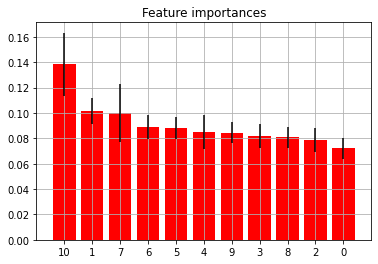

In [29]:
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.grid(True)

### Retrain Model with Feature Selection 
Based on importance of features

In [36]:
from sklearn.feature_selection import SelectFromModel

In [64]:
sfm = SelectFromModel(CV_rfc.best_estimator_, threshold=0.08)

# Train the selector
sfm.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 5000
building tree 2 of 5000
building tree 3 of 5000
building tree 4 of 5000
building tree 5 of 5000
building tree 6 of 5000
building tree 7 of 5000
building tree 8 of 5000
building tree 9 of 5000
building tree 10 of 5000
building tree 11 of 5000
building tree 12 of 5000
building tree 13 of 5000
building tree 14 of 5000
building tree 15 of 5000
building tree 16 of 5000
building tree 17 of 5000
building tree 18 of 5000
building tree 19 of 5000
building tree 20 of 5000
building tree 21 of 5000
building tree 22 of 5000
building tree 23 of 5000
building tree 24 of 5000
building tree 25 of 5000
building tree 26 of 5000
building tree 27 of 5000
building tree 28 of 5000
building tree 29 of 5000
building tree 30 of 5000
building tree 31 of 5000
building tree 32 of 5000
building tree 33 of 5000
building tree 34 of 5000
building tree 35 of 5000
building tree 36 of 5000
building tree 37 of 5000
building tree 38 of 5000
building tree 39 of 5000
building tree 40 of 5000
building 

building tree 327 of 5000
building tree 328 of 5000
building tree 329 of 5000
building tree 330 of 5000
building tree 331 of 5000
building tree 332 of 5000
building tree 333 of 5000
building tree 334 of 5000
building tree 335 of 5000
building tree 336 of 5000
building tree 337 of 5000
building tree 338 of 5000
building tree 339 of 5000
building tree 340 of 5000
building tree 341 of 5000
building tree 342 of 5000
building tree 343 of 5000
building tree 344 of 5000
building tree 345 of 5000
building tree 346 of 5000
building tree 347 of 5000
building tree 348 of 5000
building tree 349 of 5000
building tree 350 of 5000
building tree 351 of 5000
building tree 352 of 5000
building tree 353 of 5000
building tree 354 of 5000
building tree 355 of 5000
building tree 356 of 5000
building tree 357 of 5000
building tree 358 of 5000
building tree 359 of 5000
building tree 360 of 5000
building tree 361 of 5000
building tree 362 of 5000
building tree 363 of 5000
building tree 364 of 5000
building tre

building tree 663 of 5000
building tree 664 of 5000
building tree 665 of 5000
building tree 666 of 5000
building tree 667 of 5000
building tree 668 of 5000
building tree 669 of 5000
building tree 670 of 5000
building tree 671 of 5000
building tree 672 of 5000
building tree 673 of 5000
building tree 674 of 5000
building tree 675 of 5000
building tree 676 of 5000
building tree 677 of 5000
building tree 678 of 5000
building tree 679 of 5000
building tree 680 of 5000
building tree 681 of 5000
building tree 682 of 5000
building tree 683 of 5000
building tree 684 of 5000
building tree 685 of 5000
building tree 686 of 5000
building tree 687 of 5000
building tree 688 of 5000
building tree 689 of 5000
building tree 690 of 5000
building tree 691 of 5000
building tree 692 of 5000
building tree 693 of 5000
building tree 694 of 5000
building tree 695 of 5000
building tree 696 of 5000
building tree 697 of 5000
building tree 698 of 5000
building tree 699 of 5000
building tree 700 of 5000
building tre

building tree 989 of 5000
building tree 990 of 5000
building tree 991 of 5000
building tree 992 of 5000
building tree 993 of 5000
building tree 994 of 5000
building tree 995 of 5000
building tree 996 of 5000
building tree 997 of 5000
building tree 998 of 5000
building tree 999 of 5000
building tree 1000 of 5000
building tree 1001 of 5000
building tree 1002 of 5000
building tree 1003 of 5000
building tree 1004 of 5000
building tree 1005 of 5000
building tree 1006 of 5000
building tree 1007 of 5000
building tree 1008 of 5000
building tree 1009 of 5000
building tree 1010 of 5000
building tree 1011 of 5000
building tree 1012 of 5000
building tree 1013 of 5000
building tree 1014 of 5000
building tree 1015 of 5000
building tree 1016 of 5000
building tree 1017 of 5000
building tree 1018 of 5000
building tree 1019 of 5000
building tree 1020 of 5000
building tree 1021 of 5000
building tree 1022 of 5000
building tree 1023 of 5000
building tree 1024 of 5000
building tree 1025 of 5000
building tre

building tree 1295 of 5000
building tree 1296 of 5000
building tree 1297 of 5000
building tree 1298 of 5000
building tree 1299 of 5000
building tree 1300 of 5000
building tree 1301 of 5000
building tree 1302 of 5000
building tree 1303 of 5000
building tree 1304 of 5000
building tree 1305 of 5000
building tree 1306 of 5000
building tree 1307 of 5000
building tree 1308 of 5000
building tree 1309 of 5000
building tree 1310 of 5000
building tree 1311 of 5000
building tree 1312 of 5000
building tree 1313 of 5000
building tree 1314 of 5000
building tree 1315 of 5000
building tree 1316 of 5000
building tree 1317 of 5000
building tree 1318 of 5000
building tree 1319 of 5000
building tree 1320 of 5000
building tree 1321 of 5000
building tree 1322 of 5000
building tree 1323 of 5000
building tree 1324 of 5000
building tree 1325 of 5000
building tree 1326 of 5000
building tree 1327 of 5000
building tree 1328 of 5000
building tree 1329 of 5000
building tree 1330 of 5000
building tree 1331 of 5000
b

building tree 1619 of 5000
building tree 1620 of 5000
building tree 1621 of 5000
building tree 1622 of 5000
building tree 1623 of 5000
building tree 1624 of 5000
building tree 1625 of 5000
building tree 1626 of 5000
building tree 1627 of 5000
building tree 1628 of 5000
building tree 1629 of 5000
building tree 1630 of 5000
building tree 1631 of 5000
building tree 1632 of 5000
building tree 1633 of 5000
building tree 1634 of 5000
building tree 1635 of 5000
building tree 1636 of 5000
building tree 1637 of 5000
building tree 1638 of 5000
building tree 1639 of 5000
building tree 1640 of 5000
building tree 1641 of 5000
building tree 1642 of 5000
building tree 1643 of 5000
building tree 1644 of 5000
building tree 1645 of 5000
building tree 1646 of 5000
building tree 1647 of 5000
building tree 1648 of 5000
building tree 1649 of 5000
building tree 1650 of 5000
building tree 1651 of 5000
building tree 1652 of 5000
building tree 1653 of 5000
building tree 1654 of 5000
building tree 1655 of 5000
b

building tree 1923 of 5000
building tree 1924 of 5000
building tree 1925 of 5000
building tree 1926 of 5000
building tree 1927 of 5000
building tree 1928 of 5000
building tree 1929 of 5000
building tree 1930 of 5000
building tree 1931 of 5000
building tree 1932 of 5000
building tree 1933 of 5000
building tree 1934 of 5000
building tree 1935 of 5000
building tree 1936 of 5000
building tree 1937 of 5000
building tree 1938 of 5000
building tree 1939 of 5000
building tree 1940 of 5000
building tree 1941 of 5000
building tree 1942 of 5000
building tree 1943 of 5000
building tree 1944 of 5000
building tree 1945 of 5000
building tree 1946 of 5000
building tree 1947 of 5000
building tree 1948 of 5000
building tree 1949 of 5000
building tree 1950 of 5000
building tree 1951 of 5000
building tree 1952 of 5000
building tree 1953 of 5000
building tree 1954 of 5000
building tree 1955 of 5000
building tree 1956 of 5000
building tree 1957 of 5000
building tree 1958 of 5000
building tree 1959 of 5000
b

building tree 2246 of 5000
building tree 2247 of 5000
building tree 2248 of 5000
building tree 2249 of 5000
building tree 2250 of 5000
building tree 2251 of 5000
building tree 2252 of 5000
building tree 2253 of 5000
building tree 2254 of 5000
building tree 2255 of 5000
building tree 2256 of 5000
building tree 2257 of 5000
building tree 2258 of 5000
building tree 2259 of 5000
building tree 2260 of 5000
building tree 2261 of 5000
building tree 2262 of 5000
building tree 2263 of 5000
building tree 2264 of 5000
building tree 2265 of 5000
building tree 2266 of 5000
building tree 2267 of 5000
building tree 2268 of 5000
building tree 2269 of 5000
building tree 2270 of 5000
building tree 2271 of 5000
building tree 2272 of 5000
building tree 2273 of 5000
building tree 2274 of 5000
building tree 2275 of 5000
building tree 2276 of 5000
building tree 2277 of 5000
building tree 2278 of 5000
building tree 2279 of 5000
building tree 2280 of 5000
building tree 2281 of 5000
building tree 2282 of 5000
b

building tree 2550 of 5000
building tree 2551 of 5000
building tree 2552 of 5000
building tree 2553 of 5000
building tree 2554 of 5000
building tree 2555 of 5000
building tree 2556 of 5000
building tree 2557 of 5000
building tree 2558 of 5000
building tree 2559 of 5000
building tree 2560 of 5000
building tree 2561 of 5000
building tree 2562 of 5000
building tree 2563 of 5000
building tree 2564 of 5000
building tree 2565 of 5000
building tree 2566 of 5000
building tree 2567 of 5000
building tree 2568 of 5000
building tree 2569 of 5000
building tree 2570 of 5000
building tree 2571 of 5000
building tree 2572 of 5000
building tree 2573 of 5000
building tree 2574 of 5000
building tree 2575 of 5000
building tree 2576 of 5000
building tree 2577 of 5000
building tree 2578 of 5000
building tree 2579 of 5000
building tree 2580 of 5000
building tree 2581 of 5000
building tree 2582 of 5000
building tree 2583 of 5000
building tree 2584 of 5000
building tree 2585 of 5000
building tree 2586 of 5000
b

building tree 2856 of 5000
building tree 2857 of 5000
building tree 2858 of 5000
building tree 2859 of 5000
building tree 2860 of 5000
building tree 2861 of 5000
building tree 2862 of 5000
building tree 2863 of 5000
building tree 2864 of 5000
building tree 2865 of 5000
building tree 2866 of 5000
building tree 2867 of 5000
building tree 2868 of 5000
building tree 2869 of 5000
building tree 2870 of 5000
building tree 2871 of 5000
building tree 2872 of 5000
building tree 2873 of 5000
building tree 2874 of 5000
building tree 2875 of 5000
building tree 2876 of 5000
building tree 2877 of 5000
building tree 2878 of 5000
building tree 2879 of 5000
building tree 2880 of 5000
building tree 2881 of 5000
building tree 2882 of 5000
building tree 2883 of 5000
building tree 2884 of 5000
building tree 2885 of 5000
building tree 2886 of 5000
building tree 2887 of 5000
building tree 2888 of 5000
building tree 2889 of 5000
building tree 2890 of 5000
building tree 2891 of 5000
building tree 2892 of 5000
b

building tree 3173 of 5000
building tree 3174 of 5000
building tree 3175 of 5000
building tree 3176 of 5000
building tree 3177 of 5000
building tree 3178 of 5000
building tree 3179 of 5000
building tree 3180 of 5000
building tree 3181 of 5000
building tree 3182 of 5000
building tree 3183 of 5000
building tree 3184 of 5000
building tree 3185 of 5000
building tree 3186 of 5000
building tree 3187 of 5000
building tree 3188 of 5000
building tree 3189 of 5000
building tree 3190 of 5000
building tree 3191 of 5000
building tree 3192 of 5000
building tree 3193 of 5000
building tree 3194 of 5000
building tree 3195 of 5000
building tree 3196 of 5000
building tree 3197 of 5000
building tree 3198 of 5000
building tree 3199 of 5000
building tree 3200 of 5000
building tree 3201 of 5000
building tree 3202 of 5000
building tree 3203 of 5000
building tree 3204 of 5000
building tree 3205 of 5000
building tree 3206 of 5000
building tree 3207 of 5000
building tree 3208 of 5000
building tree 3209 of 5000
b

building tree 3479 of 5000
building tree 3480 of 5000
building tree 3481 of 5000
building tree 3482 of 5000
building tree 3483 of 5000
building tree 3484 of 5000
building tree 3485 of 5000
building tree 3486 of 5000
building tree 3487 of 5000
building tree 3488 of 5000
building tree 3489 of 5000
building tree 3490 of 5000
building tree 3491 of 5000
building tree 3492 of 5000
building tree 3493 of 5000
building tree 3494 of 5000
building tree 3495 of 5000
building tree 3496 of 5000
building tree 3497 of 5000
building tree 3498 of 5000
building tree 3499 of 5000
building tree 3500 of 5000
building tree 3501 of 5000
building tree 3502 of 5000
building tree 3503 of 5000
building tree 3504 of 5000
building tree 3505 of 5000
building tree 3506 of 5000
building tree 3507 of 5000
building tree 3508 of 5000
building tree 3509 of 5000
building tree 3510 of 5000
building tree 3511 of 5000
building tree 3512 of 5000
building tree 3513 of 5000
building tree 3514 of 5000
building tree 3515 of 5000
b

building tree 3798 of 5000
building tree 3799 of 5000
building tree 3800 of 5000
building tree 3801 of 5000
building tree 3802 of 5000
building tree 3803 of 5000
building tree 3804 of 5000
building tree 3805 of 5000
building tree 3806 of 5000
building tree 3807 of 5000
building tree 3808 of 5000
building tree 3809 of 5000
building tree 3810 of 5000
building tree 3811 of 5000
building tree 3812 of 5000
building tree 3813 of 5000
building tree 3814 of 5000
building tree 3815 of 5000
building tree 3816 of 5000
building tree 3817 of 5000
building tree 3818 of 5000
building tree 3819 of 5000
building tree 3820 of 5000
building tree 3821 of 5000
building tree 3822 of 5000
building tree 3823 of 5000
building tree 3824 of 5000
building tree 3825 of 5000
building tree 3826 of 5000
building tree 3827 of 5000
building tree 3828 of 5000
building tree 3829 of 5000
building tree 3830 of 5000
building tree 3831 of 5000
building tree 3832 of 5000
building tree 3833 of 5000
building tree 3834 of 5000
b

building tree 4115 of 5000
building tree 4116 of 5000
building tree 4117 of 5000
building tree 4118 of 5000
building tree 4119 of 5000
building tree 4120 of 5000
building tree 4121 of 5000
building tree 4122 of 5000
building tree 4123 of 5000
building tree 4124 of 5000
building tree 4125 of 5000
building tree 4126 of 5000
building tree 4127 of 5000
building tree 4128 of 5000
building tree 4129 of 5000
building tree 4130 of 5000
building tree 4131 of 5000
building tree 4132 of 5000
building tree 4133 of 5000
building tree 4134 of 5000
building tree 4135 of 5000
building tree 4136 of 5000
building tree 4137 of 5000
building tree 4138 of 5000
building tree 4139 of 5000
building tree 4140 of 5000
building tree 4141 of 5000
building tree 4142 of 5000
building tree 4143 of 5000
building tree 4144 of 5000
building tree 4145 of 5000
building tree 4146 of 5000
building tree 4147 of 5000
building tree 4148 of 5000
building tree 4149 of 5000
building tree 4150 of 5000
building tree 4151 of 5000
b

building tree 4429 of 5000
building tree 4430 of 5000
building tree 4431 of 5000
building tree 4432 of 5000
building tree 4433 of 5000
building tree 4434 of 5000
building tree 4435 of 5000
building tree 4436 of 5000
building tree 4437 of 5000
building tree 4438 of 5000
building tree 4439 of 5000
building tree 4440 of 5000
building tree 4441 of 5000
building tree 4442 of 5000
building tree 4443 of 5000
building tree 4444 of 5000
building tree 4445 of 5000
building tree 4446 of 5000
building tree 4447 of 5000
building tree 4448 of 5000
building tree 4449 of 5000
building tree 4450 of 5000
building tree 4451 of 5000
building tree 4452 of 5000
building tree 4453 of 5000
building tree 4454 of 5000
building tree 4455 of 5000
building tree 4456 of 5000
building tree 4457 of 5000
building tree 4458 of 5000
building tree 4459 of 5000
building tree 4460 of 5000
building tree 4461 of 5000
building tree 4462 of 5000
building tree 4463 of 5000
building tree 4464 of 5000
building tree 4465 of 5000
b

building tree 4733 of 5000
building tree 4734 of 5000
building tree 4735 of 5000
building tree 4736 of 5000
building tree 4737 of 5000
building tree 4738 of 5000
building tree 4739 of 5000
building tree 4740 of 5000
building tree 4741 of 5000
building tree 4742 of 5000
building tree 4743 of 5000
building tree 4744 of 5000
building tree 4745 of 5000
building tree 4746 of 5000
building tree 4747 of 5000
building tree 4748 of 5000
building tree 4749 of 5000
building tree 4750 of 5000
building tree 4751 of 5000
building tree 4752 of 5000
building tree 4753 of 5000
building tree 4754 of 5000
building tree 4755 of 5000
building tree 4756 of 5000
building tree 4757 of 5000
building tree 4758 of 5000
building tree 4759 of 5000
building tree 4760 of 5000
building tree 4761 of 5000
building tree 4762 of 5000
building tree 4763 of 5000
building tree 4764 of 5000
building tree 4765 of 5000
building tree 4766 of 5000
building tree 4767 of 5000
building tree 4768 of 5000
building tree 4769 of 5000
b

[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:   55.3s finished


SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='entropy',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=5000, n_jobs=None,
                                                 oob_score=Fa

In [65]:
feat_labels = wine_df.columns.tolist()

In [66]:
# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

volatile acidity
residual sugar
chlorides
free sulfur dioxide
total sulfur dioxide
density
pH
sulphates
alcohol


In [67]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

In [68]:
X_important_train.shape, X_important_test.shape

((5197, 9), (1300, 9))

In [69]:
# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=5000, random_state=42, n_jobs=10, 
                                       max_depth=None, criterion='entropy', max_features='auto', 
                                       bootstrap=True)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5000,
                       n_jobs=10, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [70]:
y_pred = clf_important.predict(X_important_test)

In [71]:
acc = accuracy_score(y_test, y_pred)*100

print("Accuracy: {}%".format(acc))

Accuracy: 67.3076923076923%


In [72]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.67      0.14      0.23        43
           5       0.67      0.72      0.70       402
           6       0.66      0.74      0.70       597
           7       0.72      0.57      0.64       215
           8       0.86      0.33      0.48        36
           9       0.00      0.00      0.00         1

    accuracy                           0.67      1300
   macro avg       0.51      0.36      0.39      1300
weighted avg       0.68      0.67      0.66      1300

